In [16]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4200      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

943/943 [==============================] - 2s 2ms/step - loss: 0.3687 - accuracy: 0.8320 - val_loss: 0.3383 - val_accuracy: 0.8446
Epoch 50/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3674 - accuracy: 0.8301 - val_loss: 0.3383 - val_accuracy: 0.8445
Epoch 51/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3687 - accuracy: 0.8321 - val_loss: 0.3382 - val_accuracy: 0.8445
Epoch 52/100
943/943 [==============================] - 1s 2ms/step - loss: 0.3676 - accuracy: 0.8314 - val_loss: 0.3382 - val_accuracy: 0.8446
Epoch 53/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3660 - accuracy: 0.8335 - val_loss: 0.3382 - val_accuracy: 0.8446
Epoch 54/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3658 - accuracy: 0.8324 - val_loss: 0.3381 - val_accuracy: 0.8447
Epoch 55/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3646 - accuracy: 0.8316 - val_loss: 0.3381 - val_accuracy: 0.8447
Epoch

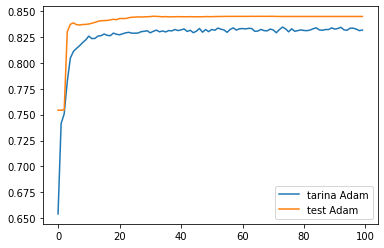

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do do modelu 
```python
model.add(Dropout(0.8))
```
po każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

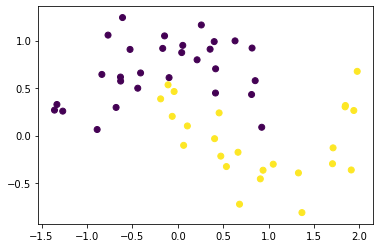

In [17]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [18]:
from tensorflow.keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1000)              3000      
_________________________________________________________________
dense_17 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_18 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 75ms/step - loss: 0.8019 - accuracy: 0.4151 - val_loss: 0.6743 - val_accuracy: 0.5532
Epoch 2/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.7254 - accuracy: 0.3962 - val_

2/2 [==============================] - 0s 14ms/step - loss: 0.1940 - accuracy: 0.9245 - val_loss: 0.4797 - val_accuracy: 0.8298
Epoch 53/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1915 - accuracy: 0.9057 - val_loss: 0.4904 - val_accuracy: 0.8298
Epoch 54/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1929 - accuracy: 0.9057 - val_loss: 0.4893 - val_accuracy: 0.8298
Epoch 55/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.1906 - accuracy: 0.9057 - val_loss: 0.4996 - val_accuracy: 0.8085
Epoch 56/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1883 - accuracy: 0.9245 - val_loss: 0.4855 - val_accuracy: 0.8298
Epoch 57/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1850 - accuracy: 0.9245 - val_loss: 0.4777 - val_accuracy: 0.8298
Epoch 58/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1858 - accuracy: 0.9245 - val_loss: 0.4741 - val_accuracy: 0.8298
Epoch 59/1000
2/2 [=

Epoch 110/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0685 - accuracy: 1.0000 - val_loss: 0.2095 - val_accuracy: 0.9149
Epoch 111/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0637 - accuracy: 0.9811 - val_loss: 0.2232 - val_accuracy: 0.9149
Epoch 112/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0644 - accuracy: 0.9623 - val_loss: 0.2329 - val_accuracy: 0.9149
Epoch 113/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0622 - accuracy: 0.9623 - val_loss: 0.2226 - val_accuracy: 0.9149
Epoch 114/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0586 - accuracy: 0.9811 - val_loss: 0.2034 - val_accuracy: 0.9149
Epoch 115/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0566 - accuracy: 1.0000 - val_loss: 0.1924 - val_accuracy: 0.8936
Epoch 116/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 0.1895 - val_accuracy: 0.8936

2/2 [==============================] - 0s 14ms/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 0.1798 - val_accuracy: 0.8936
Epoch 168/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0188 - accuracy: 1.0000 - val_loss: 0.1805 - val_accuracy: 0.8936
Epoch 169/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.1836 - val_accuracy: 0.9362
Epoch 170/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.1853 - val_accuracy: 0.9362
Epoch 171/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.1806 - val_accuracy: 0.9149
Epoch 172/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.1745 - val_accuracy: 0.8936
Epoch 173/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 0.1736 - val_accuracy: 0.9149
Epoch 174/1000

2/2 [==============================] - 0s 16ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1949 - val_accuracy: 0.9149
Epoch 225/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.1935 - val_accuracy: 0.9149
Epoch 226/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1927 - val_accuracy: 0.9149
Epoch 227/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1928 - val_accuracy: 0.9149
Epoch 228/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.1928 - val_accuracy: 0.9149
Epoch 229/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.1930 - val_accuracy: 0.9149
Epoch 230/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.1932 - val_accuracy: 0.9149
Epoch 231/1000

2/2 [==============================] - 0s 20ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.2066 - val_accuracy: 0.9149
Epoch 282/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2086 - val_accuracy: 0.9149
Epoch 283/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.2098 - val_accuracy: 0.9149
Epoch 284/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2101 - val_accuracy: 0.9149
Epoch 285/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.2107 - val_accuracy: 0.9149
Epoch 286/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2116 - val_accuracy: 0.9149
Epoch 287/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2133 - val_accuracy: 0.9149
Epoch 288/1000

2/2 [==============================] - 0s 17ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2230 - val_accuracy: 0.9149
Epoch 339/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2235 - val_accuracy: 0.9149
Epoch 340/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2242 - val_accuracy: 0.9149
Epoch 341/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2238 - val_accuracy: 0.9149
Epoch 342/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2235 - val_accuracy: 0.9149
Epoch 343/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2236 - val_accuracy: 0.9149
Epoch 344/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2242 - val_accuracy: 0.9149
Epoch 345/1000

2/2 [==============================] - 0s 17ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2400 - val_accuracy: 0.9149
Epoch 396/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2391 - val_accuracy: 0.9149
Epoch 397/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2374 - val_accuracy: 0.9149
Epoch 398/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2367 - val_accuracy: 0.9149
Epoch 399/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2369 - val_accuracy: 0.9149
Epoch 400/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2388 - val_accuracy: 0.9149
Epoch 401/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2395 - val_accuracy: 0.9149
Epoch 402/1000

2/2 [==============================] - 0s 21ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2585 - val_accuracy: 0.9149
Epoch 453/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2591 - val_accuracy: 0.9149
Epoch 454/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2581 - val_accuracy: 0.9149
Epoch 455/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2579 - val_accuracy: 0.9149
Epoch 456/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2562 - val_accuracy: 0.9149
Epoch 457/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2551 - val_accuracy: 0.9149
Epoch 458/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2547 - val_accuracy: 0.9149
Epoch 459/1000

2/2 [==============================] - 0s 16ms/step - loss: 9.3408e-04 - accuracy: 1.0000 - val_loss: 0.2674 - val_accuracy: 0.9149
Epoch 510/1000
2/2 [==============================] - 0s 18ms/step - loss: 9.1628e-04 - accuracy: 1.0000 - val_loss: 0.2676 - val_accuracy: 0.9149
Epoch 511/1000
2/2 [==============================] - 0s 22ms/step - loss: 9.0310e-04 - accuracy: 1.0000 - val_loss: 0.2670 - val_accuracy: 0.9149
Epoch 512/1000
2/2 [==============================] - 0s 24ms/step - loss: 9.0077e-04 - accuracy: 1.0000 - val_loss: 0.2659 - val_accuracy: 0.9149
Epoch 513/1000
2/2 [==============================] - 0s 16ms/step - loss: 9.2075e-04 - accuracy: 1.0000 - val_loss: 0.2660 - val_accuracy: 0.9149
Epoch 514/1000
2/2 [==============================] - 0s 14ms/step - loss: 9.1396e-04 - accuracy: 1.0000 - val_loss: 0.2662 - val_accuracy: 0.9149
Epoch 515/1000
2/2 [==============================] - 0s 15ms/step - loss: 9.1793e-04 - accuracy: 1.0000 - val_loss: 0.2673 - val_acc

Epoch 565/1000
2/2 [==============================] - 0s 19ms/step - loss: 7.1031e-04 - accuracy: 1.0000 - val_loss: 0.2833 - val_accuracy: 0.9149
Epoch 566/1000
2/2 [==============================] - 0s 16ms/step - loss: 6.9302e-04 - accuracy: 1.0000 - val_loss: 0.2829 - val_accuracy: 0.9149
Epoch 567/1000
2/2 [==============================] - 0s 15ms/step - loss: 7.1680e-04 - accuracy: 1.0000 - val_loss: 0.2828 - val_accuracy: 0.9149
Epoch 568/1000
2/2 [==============================] - 0s 15ms/step - loss: 6.9176e-04 - accuracy: 1.0000 - val_loss: 0.2840 - val_accuracy: 0.9149
Epoch 569/1000
2/2 [==============================] - 0s 15ms/step - loss: 6.8402e-04 - accuracy: 1.0000 - val_loss: 0.2851 - val_accuracy: 0.9149
Epoch 570/1000
2/2 [==============================] - 0s 18ms/step - loss: 6.8521e-04 - accuracy: 1.0000 - val_loss: 0.2859 - val_accuracy: 0.9149
Epoch 571/1000
2/2 [==============================] - 0s 14ms/step - loss: 7.1031e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 621/1000
2/2 [==============================] - 0s 16ms/step - loss: 5.6405e-04 - accuracy: 1.0000 - val_loss: 0.2919 - val_accuracy: 0.9149
Epoch 622/1000
2/2 [==============================] - 0s 16ms/step - loss: 5.4418e-04 - accuracy: 1.0000 - val_loss: 0.2940 - val_accuracy: 0.9149
Epoch 623/1000
2/2 [==============================] - 0s 21ms/step - loss: 5.3189e-04 - accuracy: 1.0000 - val_loss: 0.2966 - val_accuracy: 0.9149
Epoch 624/1000
2/2 [==============================] - 0s 17ms/step - loss: 5.4604e-04 - accuracy: 1.0000 - val_loss: 0.2992 - val_accuracy: 0.9149
Epoch 625/1000
2/2 [==============================] - 0s 18ms/step - loss: 5.6137e-04 - accuracy: 1.0000 - val_loss: 0.3003 - val_accuracy: 0.9149
Epoch 626/1000
2/2 [==============================] - 0s 17ms/step - loss: 5.7368e-04 - accuracy: 1.0000 - val_loss: 0.3007 - val_accuracy: 0.9149
Epoch 627/1000
2/2 [==============================] - 0s 20ms/step - loss: 5.7061e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 677/1000
2/2 [==============================] - 0s 17ms/step - loss: 4.3961e-04 - accuracy: 1.0000 - val_loss: 0.3083 - val_accuracy: 0.9149
Epoch 678/1000
2/2 [==============================] - 0s 21ms/step - loss: 4.4613e-04 - accuracy: 1.0000 - val_loss: 0.3085 - val_accuracy: 0.9149
Epoch 679/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.4949e-04 - accuracy: 1.0000 - val_loss: 0.3096 - val_accuracy: 0.9149
Epoch 680/1000
2/2 [==============================] - 0s 17ms/step - loss: 4.3560e-04 - accuracy: 1.0000 - val_loss: 0.3093 - val_accuracy: 0.9149
Epoch 681/1000
2/2 [==============================] - 0s 18ms/step - loss: 4.3763e-04 - accuracy: 1.0000 - val_loss: 0.3091 - val_accuracy: 0.9149
Epoch 682/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.4750e-04 - accuracy: 1.0000 - val_loss: 0.3078 - val_accuracy: 0.9149
Epoch 683/1000
2/2 [==============================] - 0s 17ms/step - loss: 4.3114e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 733/1000
2/2 [==============================] - 0s 17ms/step - loss: 3.6273e-04 - accuracy: 1.0000 - val_loss: 0.3214 - val_accuracy: 0.9149
Epoch 734/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.7107e-04 - accuracy: 1.0000 - val_loss: 0.3229 - val_accuracy: 0.9149
Epoch 735/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.5928e-04 - accuracy: 1.0000 - val_loss: 0.3231 - val_accuracy: 0.9149
Epoch 736/1000
2/2 [==============================] - 0s 22ms/step - loss: 3.6137e-04 - accuracy: 1.0000 - val_loss: 0.3231 - val_accuracy: 0.9149
Epoch 737/1000
2/2 [==============================] - 0s 20ms/step - loss: 3.5584e-04 - accuracy: 1.0000 - val_loss: 0.3220 - val_accuracy: 0.9149
Epoch 738/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.5383e-04 - accuracy: 1.0000 - val_loss: 0.3211 - val_accuracy: 0.9149
Epoch 739/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.5502e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 789/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.9892e-04 - accuracy: 1.0000 - val_loss: 0.3320 - val_accuracy: 0.9149
Epoch 790/1000
2/2 [==============================] - 0s 21ms/step - loss: 2.9796e-04 - accuracy: 1.0000 - val_loss: 0.3323 - val_accuracy: 0.9149
Epoch 791/1000
2/2 [==============================] - 0s 18ms/step - loss: 2.9734e-04 - accuracy: 1.0000 - val_loss: 0.3326 - val_accuracy: 0.9149
Epoch 792/1000
2/2 [==============================] - 0s 17ms/step - loss: 3.0096e-04 - accuracy: 1.0000 - val_loss: 0.3328 - val_accuracy: 0.9149
Epoch 793/1000
2/2 [==============================] - 0s 18ms/step - loss: 2.9541e-04 - accuracy: 1.0000 - val_loss: 0.3337 - val_accuracy: 0.9149
Epoch 794/1000
2/2 [==============================] - 0s 18ms/step - loss: 2.9451e-04 - accuracy: 1.0000 - val_loss: 0.3343 - val_accuracy: 0.9149
Epoch 795/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.9387e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 845/1000
2/2 [==============================] - 0s 22ms/step - loss: 2.5150e-04 - accuracy: 1.0000 - val_loss: 0.3437 - val_accuracy: 0.9149
Epoch 846/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.5405e-04 - accuracy: 1.0000 - val_loss: 0.3440 - val_accuracy: 0.9149
Epoch 847/1000
2/2 [==============================] - 0s 23ms/step - loss: 2.4998e-04 - accuracy: 1.0000 - val_loss: 0.3449 - val_accuracy: 0.9149
Epoch 848/1000
2/2 [==============================] - 0s 21ms/step - loss: 2.5517e-04 - accuracy: 1.0000 - val_loss: 0.3456 - val_accuracy: 0.9149
Epoch 849/1000
2/2 [==============================] - 0s 21ms/step - loss: 2.4908e-04 - accuracy: 1.0000 - val_loss: 0.3454 - val_accuracy: 0.9149
Epoch 850/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.4773e-04 - accuracy: 1.0000 - val_loss: 0.3453 - val_accuracy: 0.9149
Epoch 851/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.4723e-04 - accuracy: 1.0000 - val_loss: 0

2/2 [==============================] - 0s 17ms/step - loss: 2.1854e-04 - accuracy: 1.0000 - val_loss: 0.3540 - val_accuracy: 0.9149
Epoch 901/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.1506e-04 - accuracy: 1.0000 - val_loss: 0.3548 - val_accuracy: 0.9149
Epoch 902/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.1416e-04 - accuracy: 1.0000 - val_loss: 0.3555 - val_accuracy: 0.9149
Epoch 903/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.1487e-04 - accuracy: 1.0000 - val_loss: 0.3558 - val_accuracy: 0.9149
Epoch 904/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.1351e-04 - accuracy: 1.0000 - val_loss: 0.3566 - val_accuracy: 0.9149
Epoch 905/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.1359e-04 - accuracy: 1.0000 - val_loss: 0.3570 - val_accuracy: 0.9149
Epoch 906/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.1565e-04 - accuracy: 1.0000 - val_loss: 0.3570 - val_acc

Epoch 956/1000
2/2 [==============================] - 0s 18ms/step - loss: 1.8469e-04 - accuracy: 1.0000 - val_loss: 0.3655 - val_accuracy: 0.9149
Epoch 957/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.8416e-04 - accuracy: 1.0000 - val_loss: 0.3657 - val_accuracy: 0.9149
Epoch 958/1000
2/2 [==============================] - 0s 21ms/step - loss: 1.8365e-04 - accuracy: 1.0000 - val_loss: 0.3657 - val_accuracy: 0.9149
Epoch 959/1000
2/2 [==============================] - 0s 20ms/step - loss: 1.8580e-04 - accuracy: 1.0000 - val_loss: 0.3657 - val_accuracy: 0.9149
Epoch 960/1000
2/2 [==============================] - 0s 21ms/step - loss: 1.8619e-04 - accuracy: 1.0000 - val_loss: 0.3665 - val_accuracy: 0.9149
Epoch 961/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.8210e-04 - accuracy: 1.0000 - val_loss: 0.3666 - val_accuracy: 0.9149
Epoch 962/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.8177e-04 - accuracy: 1.0000 - val_loss: 0

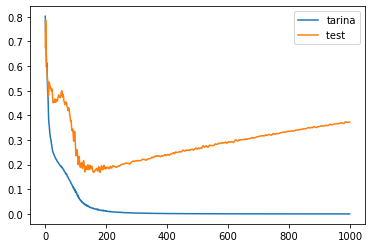

In [19]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


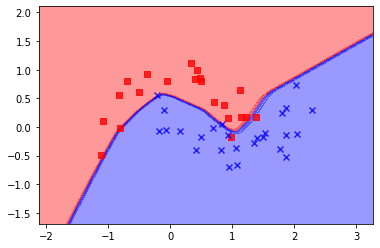

In [20]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

In [21]:
from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam_1 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.8))
model.add(Dense(500,activation="sigmoid"))
model.add(Dropout(0.8))
model.add(Dense(200,activation="sigmoid"))
model.add(Dropout(0.8))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_1])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1000)              3000      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 500)               500500    
_________________________________________________________________
dropout_7 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

Epoch 50/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.5882 - accuracy: 0.8113 - val_loss: 0.4644 - val_accuracy: 0.7447
Epoch 51/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.3689 - accuracy: 0.8491 - val_loss: 0.4655 - val_accuracy: 0.7447
Epoch 52/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.4173 - accuracy: 0.8491 - val_loss: 0.4667 - val_accuracy: 0.7447
Epoch 53/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.4142 - accuracy: 0.8491 - val_loss: 0.4691 - val_accuracy: 0.7447
Epoch 54/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.4094 - accuracy: 0.8491 - val_loss: 0.4706 - val_accuracy: 0.7660
Epoch 55/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.3804 - accuracy: 0.8302 - val_loss: 0.4724 - val_accuracy: 0.7660
Epoch 56/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3956 - accuracy: 0.8679 - val_loss: 0.4737 - val_accuracy: 0.7660
Epoch 

2/2 [==============================] - 0s 15ms/step - loss: 0.2295 - accuracy: 0.8679 - val_loss: 0.5499 - val_accuracy: 0.7872
Epoch 108/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2966 - accuracy: 0.9057 - val_loss: 0.5515 - val_accuracy: 0.7872
Epoch 109/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.3445 - accuracy: 0.8868 - val_loss: 0.5514 - val_accuracy: 0.7872
Epoch 110/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3232 - accuracy: 0.8491 - val_loss: 0.5503 - val_accuracy: 0.7872
Epoch 111/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.3109 - accuracy: 0.8868 - val_loss: 0.5488 - val_accuracy: 0.7872
Epoch 112/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2840 - accuracy: 0.8868 - val_loss: 0.5467 - val_accuracy: 0.7872
Epoch 113/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2470 - accuracy: 0.8868 - val_loss: 0.5454 - val_accuracy: 0.7872
Epoch 114/1000

2/2 [==============================] - 0s 17ms/step - loss: 0.2102 - accuracy: 0.9245 - val_loss: 0.5046 - val_accuracy: 0.8298
Epoch 165/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.2211 - accuracy: 0.9245 - val_loss: 0.5034 - val_accuracy: 0.8085
Epoch 166/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.2905 - accuracy: 0.8868 - val_loss: 0.5010 - val_accuracy: 0.8085
Epoch 167/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.2324 - accuracy: 0.8868 - val_loss: 0.4982 - val_accuracy: 0.7872
Epoch 168/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.3224 - accuracy: 0.8491 - val_loss: 0.4955 - val_accuracy: 0.7872
Epoch 169/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.2412 - accuracy: 0.9245 - val_loss: 0.4928 - val_accuracy: 0.7872
Epoch 170/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.1989 - accuracy: 0.9245 - val_loss: 0.4904 - val_accuracy: 0.7872
Epoch 171/1000

2/2 [==============================] - 0s 19ms/step - loss: 0.1841 - accuracy: 0.9057 - val_loss: 0.5069 - val_accuracy: 0.8085
Epoch 222/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.2154 - accuracy: 0.9245 - val_loss: 0.5077 - val_accuracy: 0.8085
Epoch 223/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2168 - accuracy: 0.8868 - val_loss: 0.5082 - val_accuracy: 0.8085
Epoch 224/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.2113 - accuracy: 0.9245 - val_loss: 0.5060 - val_accuracy: 0.8085
Epoch 225/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.2286 - accuracy: 0.9245 - val_loss: 0.5020 - val_accuracy: 0.8085
Epoch 226/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.1693 - accuracy: 0.9245 - val_loss: 0.4978 - val_accuracy: 0.8085
Epoch 227/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.2373 - accuracy: 0.9245 - val_loss: 0.4927 - val_accuracy: 0.8085
Epoch 228/1000

Epoch 278/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.1440 - accuracy: 0.9623 - val_loss: 0.4760 - val_accuracy: 0.8085
Epoch 279/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1918 - accuracy: 0.9057 - val_loss: 0.4769 - val_accuracy: 0.8085
Epoch 280/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2135 - accuracy: 0.9245 - val_loss: 0.4762 - val_accuracy: 0.8085
Epoch 281/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.1954 - accuracy: 0.9245 - val_loss: 0.4755 - val_accuracy: 0.8085
Epoch 282/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.1607 - accuracy: 0.9057 - val_loss: 0.4748 - val_accuracy: 0.8085
Epoch 283/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2044 - accuracy: 0.9245 - val_loss: 0.4731 - val_accuracy: 0.8085
Epoch 284/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2473 - accuracy: 0.8868 - val_loss: 0.4714 - val_accuracy: 0.8085

Epoch 335/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2013 - accuracy: 0.9057 - val_loss: 0.4586 - val_accuracy: 0.8085
Epoch 336/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2149 - accuracy: 0.8679 - val_loss: 0.4601 - val_accuracy: 0.8085
Epoch 337/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2210 - accuracy: 0.9245 - val_loss: 0.4629 - val_accuracy: 0.8085
Epoch 338/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1811 - accuracy: 0.9623 - val_loss: 0.4648 - val_accuracy: 0.8085
Epoch 339/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2098 - accuracy: 0.8868 - val_loss: 0.4639 - val_accuracy: 0.8085
Epoch 340/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1961 - accuracy: 0.8868 - val_loss: 0.4621 - val_accuracy: 0.8085
Epoch 341/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2128 - accuracy: 0.9245 - val_loss: 0.4595 - val_accuracy: 0.8085

2/2 [==============================] - 0s 15ms/step - loss: 0.1425 - accuracy: 0.9434 - val_loss: 0.4315 - val_accuracy: 0.8511
Epoch 393/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1824 - accuracy: 0.9245 - val_loss: 0.4283 - val_accuracy: 0.8511
Epoch 394/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2396 - accuracy: 0.9057 - val_loss: 0.4262 - val_accuracy: 0.8511
Epoch 395/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2390 - accuracy: 0.9057 - val_loss: 0.4244 - val_accuracy: 0.8511
Epoch 396/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1920 - accuracy: 0.9434 - val_loss: 0.4231 - val_accuracy: 0.8511
Epoch 397/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1948 - accuracy: 0.9623 - val_loss: 0.4206 - val_accuracy: 0.8511
Epoch 398/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.1973 - accuracy: 0.9245 - val_loss: 0.4168 - val_accuracy: 0.8511
Epoch 399/1000

2/2 [==============================] - 0s 15ms/step - loss: 0.1443 - accuracy: 0.9811 - val_loss: 0.4373 - val_accuracy: 0.8511
Epoch 450/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1545 - accuracy: 0.9434 - val_loss: 0.4389 - val_accuracy: 0.8511
Epoch 451/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1970 - accuracy: 0.9057 - val_loss: 0.4385 - val_accuracy: 0.8511
Epoch 452/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1175 - accuracy: 0.9623 - val_loss: 0.4353 - val_accuracy: 0.8511
Epoch 453/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.1738 - accuracy: 0.8868 - val_loss: 0.4329 - val_accuracy: 0.8511
Epoch 454/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.1628 - accuracy: 0.9623 - val_loss: 0.4303 - val_accuracy: 0.8511
Epoch 455/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1683 - accuracy: 0.8868 - val_loss: 0.4282 - val_accuracy: 0.8511
Epoch 456/1000

2/2 [==============================] - 0s 17ms/step - loss: 0.1229 - accuracy: 0.9623 - val_loss: 0.3979 - val_accuracy: 0.8511
Epoch 507/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1879 - accuracy: 0.9245 - val_loss: 0.4008 - val_accuracy: 0.8511
Epoch 508/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.1300 - accuracy: 0.9623 - val_loss: 0.4036 - val_accuracy: 0.8511
Epoch 509/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1166 - accuracy: 0.9623 - val_loss: 0.4073 - val_accuracy: 0.8511
Epoch 510/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1540 - accuracy: 0.9245 - val_loss: 0.4114 - val_accuracy: 0.8511
Epoch 511/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2387 - accuracy: 0.8679 - val_loss: 0.4127 - val_accuracy: 0.8511
Epoch 512/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.1454 - accuracy: 0.9434 - val_loss: 0.4140 - val_accuracy: 0.8511
Epoch 513/1000

2/2 [==============================] - 0s 16ms/step - loss: 0.1328 - accuracy: 0.9623 - val_loss: 0.3694 - val_accuracy: 0.8723
Epoch 564/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1135 - accuracy: 0.9623 - val_loss: 0.3687 - val_accuracy: 0.8723
Epoch 565/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1497 - accuracy: 0.9245 - val_loss: 0.3687 - val_accuracy: 0.8723
Epoch 566/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.1015 - accuracy: 0.9623 - val_loss: 0.3680 - val_accuracy: 0.8723
Epoch 567/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0944 - accuracy: 0.9623 - val_loss: 0.3695 - val_accuracy: 0.8723
Epoch 568/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.1874 - accuracy: 0.9434 - val_loss: 0.3734 - val_accuracy: 0.8723
Epoch 569/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.1296 - accuracy: 0.9245 - val_loss: 0.3769 - val_accuracy: 0.8723
Epoch 570/1000

2/2 [==============================] - 0s 18ms/step - loss: 0.1324 - accuracy: 0.9434 - val_loss: 0.3257 - val_accuracy: 0.8723
Epoch 621/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.1744 - accuracy: 0.9057 - val_loss: 0.3308 - val_accuracy: 0.8723
Epoch 622/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0782 - accuracy: 0.9623 - val_loss: 0.3359 - val_accuracy: 0.8936
Epoch 623/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1353 - accuracy: 0.9245 - val_loss: 0.3377 - val_accuracy: 0.8936
Epoch 624/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1365 - accuracy: 0.9245 - val_loss: 0.3360 - val_accuracy: 0.8723
Epoch 625/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.1172 - accuracy: 0.9434 - val_loss: 0.3353 - val_accuracy: 0.8723
Epoch 626/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0685 - accuracy: 0.9623 - val_loss: 0.3370 - val_accuracy: 0.8723
Epoch 627/1000

2/2 [==============================] - 0s 16ms/step - loss: 0.0795 - accuracy: 0.9623 - val_loss: 0.3063 - val_accuracy: 0.8936
Epoch 678/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.1112 - accuracy: 0.9623 - val_loss: 0.3097 - val_accuracy: 0.8936
Epoch 679/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0546 - accuracy: 0.9811 - val_loss: 0.3107 - val_accuracy: 0.8936
Epoch 680/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1449 - accuracy: 0.9434 - val_loss: 0.3128 - val_accuracy: 0.8936
Epoch 681/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1641 - accuracy: 0.9434 - val_loss: 0.3117 - val_accuracy: 0.8936
Epoch 682/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0600 - accuracy: 0.9811 - val_loss: 0.3095 - val_accuracy: 0.8936
Epoch 683/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0454 - accuracy: 0.9623 - val_loss: 0.3058 - val_accuracy: 0.8936
Epoch 684/1000

2/2 [==============================] - 0s 18ms/step - loss: 0.0753 - accuracy: 0.9811 - val_loss: 0.2670 - val_accuracy: 0.8936
Epoch 735/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1067 - accuracy: 0.9811 - val_loss: 0.2666 - val_accuracy: 0.8936
Epoch 736/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1050 - accuracy: 0.9434 - val_loss: 0.2632 - val_accuracy: 0.8936
Epoch 737/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1052 - accuracy: 0.9434 - val_loss: 0.2612 - val_accuracy: 0.8936
Epoch 738/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 0.2614 - val_accuracy: 0.8936
Epoch 739/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0885 - accuracy: 0.9623 - val_loss: 0.2630 - val_accuracy: 0.8936
Epoch 740/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0855 - accuracy: 0.9623 - val_loss: 0.2615 - val_accuracy: 0.8936
Epoch 741/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.2518 - accuracy: 0.9434 - val_loss: 0.2644 - val_accuracy: 0.8936
Epoch 792/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0680 - accuracy: 0.9623 - val_loss: 0.2665 - val_accuracy: 0.8936
Epoch 793/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0719 - accuracy: 0.9623 - val_loss: 0.2707 - val_accuracy: 0.8936
Epoch 794/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0755 - accuracy: 0.9623 - val_loss: 0.2727 - val_accuracy: 0.8936
Epoch 795/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1044 - accuracy: 0.9434 - val_loss: 0.2760 - val_accuracy: 0.8936
Epoch 796/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1641 - accuracy: 0.9434 - val_loss: 0.2760 - val_accuracy: 0.8936
Epoch 797/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.2739 - val_accuracy: 0.8936
Epoch 798/1000

2/2 [==============================] - 0s 16ms/step - loss: 0.0599 - accuracy: 0.9811 - val_loss: 0.2950 - val_accuracy: 0.8936
Epoch 849/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0944 - accuracy: 0.9434 - val_loss: 0.2938 - val_accuracy: 0.8936
Epoch 850/1000
2/2 [==============================] - 0s 42ms/step - loss: 0.0676 - accuracy: 0.9623 - val_loss: 0.2919 - val_accuracy: 0.8936
Epoch 851/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0621 - accuracy: 0.9811 - val_loss: 0.2889 - val_accuracy: 0.8936
Epoch 852/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.1350 - accuracy: 0.9434 - val_loss: 0.2836 - val_accuracy: 0.8936
Epoch 853/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.1387 - accuracy: 0.9623 - val_loss: 0.2801 - val_accuracy: 0.8936
Epoch 854/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0584 - accuracy: 0.9811 - val_loss: 0.2796 - val_accuracy: 0.8936
Epoch 855/1000

2/2 [==============================] - 0s 21ms/step - loss: 0.1094 - accuracy: 0.9434 - val_loss: 0.2741 - val_accuracy: 0.8936
Epoch 906/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0720 - accuracy: 0.9623 - val_loss: 0.2662 - val_accuracy: 0.8936
Epoch 907/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.0880 - accuracy: 0.9623 - val_loss: 0.2598 - val_accuracy: 0.8936
Epoch 908/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 0.2547 - val_accuracy: 0.8936
Epoch 909/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0679 - accuracy: 0.9811 - val_loss: 0.2484 - val_accuracy: 0.8936
Epoch 910/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0333 - accuracy: 1.0000 - val_loss: 0.2420 - val_accuracy: 0.8723
Epoch 911/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.2370 - val_accuracy: 0.8936
Epoch 912/1000

2/2 [==============================] - 0s 16ms/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.2568 - val_accuracy: 0.9149
Epoch 963/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0330 - accuracy: 0.9811 - val_loss: 0.2564 - val_accuracy: 0.9149
Epoch 964/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0320 - accuracy: 1.0000 - val_loss: 0.2554 - val_accuracy: 0.9149
Epoch 965/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0402 - accuracy: 0.9811 - val_loss: 0.2553 - val_accuracy: 0.9149
Epoch 966/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0350 - accuracy: 1.0000 - val_loss: 0.2546 - val_accuracy: 0.9149
Epoch 967/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0790 - accuracy: 0.9623 - val_loss: 0.2553 - val_accuracy: 0.9149
Epoch 968/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0929 - accuracy: 0.9623 - val_loss: 0.2564 - val_accuracy: 0.9149
Epoch 969/1000

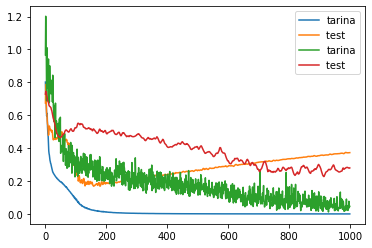

In [22]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

plt.plot(history_Adam_1.history['loss'], label = "tarina")
plt.plot(history_Adam_1.history['val_loss'], label = "test ")

plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


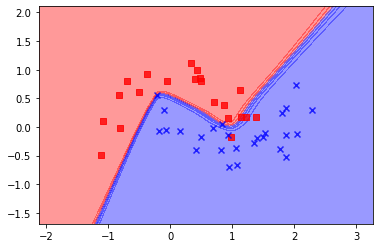

In [23]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

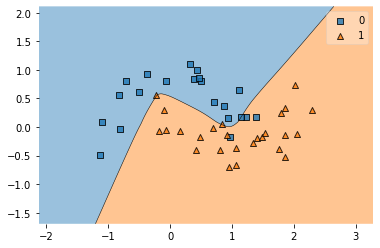

In [24]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Regularyzacja

# Zad.
Do do modelu 
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.0001)))
```

* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.0001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

In [13]:
from tensorflow.keras.callbacks import History
from tensorflow.keras.regularizers import l1


history_Adam_2 = History()
model = Sequential()
model.add(Dense(1000,activation="sigmoid",input_shape=(X_train.shape[1],), activity_regularizer=l1(0.00001)))
model.add(Dense(500,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(200,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_2])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1000)              3000      
_________________________________________________________________
dense_13 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_14 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 103ms/step - loss: 0.7759 - accuracy: 0.5094 - val_loss: 0.8096 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.7910 - accuracy: 0.4151 - val

2/2 [==============================] - 0s 16ms/step - loss: 0.3609 - accuracy: 0.8113 - val_loss: 0.4901 - val_accuracy: 0.7447
Epoch 53/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.3469 - accuracy: 0.8491 - val_loss: 0.5118 - val_accuracy: 0.7660
Epoch 54/1000
2/2 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.90 - 0s 18ms/step - loss: 0.3262 - accuracy: 0.8679 - val_loss: 0.4767 - val_accuracy: 0.7447
Epoch 55/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.3382 - accuracy: 0.8302 - val_loss: 0.4848 - val_accuracy: 0.7447
Epoch 56/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.3261 - accuracy: 0.8491 - val_loss: 0.5302 - val_accuracy: 0.7872
Epoch 57/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.3333 - accuracy: 0.8679 - val_loss: 0.5441 - val_accuracy: 0.7872
Epoch 58/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.3171 - accuracy: 0.8491 - val_loss: 0.4766 -

2/2 [==============================] - 0s 17ms/step - loss: 0.2766 - accuracy: 0.8491 - val_loss: 0.6199 - val_accuracy: 0.7660
Epoch 110/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.2782 - accuracy: 0.8491 - val_loss: 0.5174 - val_accuracy: 0.7872
Epoch 111/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2577 - accuracy: 0.9057 - val_loss: 0.4552 - val_accuracy: 0.8085
Epoch 112/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2920 - accuracy: 0.9057 - val_loss: 0.4804 - val_accuracy: 0.8085
Epoch 113/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2675 - accuracy: 0.9057 - val_loss: 0.5339 - val_accuracy: 0.7660
Epoch 114/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2752 - accuracy: 0.8868 - val_loss: 0.5949 - val_accuracy: 0.7660
Epoch 115/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2674 - accuracy: 0.8679 - val_loss: 0.5019 - val_accuracy: 0.7872
Epoch 116/1000

2/2 [==============================] - 0s 18ms/step - loss: 0.2621 - accuracy: 0.9057 - val_loss: 0.5429 - val_accuracy: 0.7660
Epoch 167/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.2581 - accuracy: 0.9057 - val_loss: 0.5637 - val_accuracy: 0.7660
Epoch 168/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.2632 - accuracy: 0.8679 - val_loss: 0.5507 - val_accuracy: 0.7660
Epoch 169/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.2615 - accuracy: 0.9057 - val_loss: 0.5035 - val_accuracy: 0.8085
Epoch 170/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.2629 - accuracy: 0.8868 - val_loss: 0.5284 - val_accuracy: 0.7660
Epoch 171/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2589 - accuracy: 0.9057 - val_loss: 0.5679 - val_accuracy: 0.7660
Epoch 172/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.2612 - accuracy: 0.9057 - val_loss: 0.5534 - val_accuracy: 0.7660
Epoch 173/1000

Epoch 223/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2580 - accuracy: 0.9057 - val_loss: 0.5574 - val_accuracy: 0.7660
Epoch 224/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.2592 - accuracy: 0.9057 - val_loss: 0.5446 - val_accuracy: 0.7660
Epoch 225/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2696 - accuracy: 0.9057 - val_loss: 0.5195 - val_accuracy: 0.7660
Epoch 226/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2578 - accuracy: 0.9057 - val_loss: 0.5524 - val_accuracy: 0.7660
Epoch 227/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2669 - accuracy: 0.8679 - val_loss: 0.5576 - val_accuracy: 0.7660
Epoch 228/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2575 - accuracy: 0.9057 - val_loss: 0.5051 - val_accuracy: 0.7872
Epoch 229/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2631 - accuracy: 0.8868 - val_loss: 0.4807 - val_accuracy: 0.8085

2/2 [==============================] - 0s 13ms/step - loss: 0.2679 - accuracy: 0.8868 - val_loss: 0.5180 - val_accuracy: 0.7660
Epoch 281/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2585 - accuracy: 0.9057 - val_loss: 0.5352 - val_accuracy: 0.7660
Epoch 282/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2638 - accuracy: 0.9057 - val_loss: 0.5626 - val_accuracy: 0.7660
Epoch 283/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2582 - accuracy: 0.9057 - val_loss: 0.5343 - val_accuracy: 0.7660
Epoch 284/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2583 - accuracy: 0.9057 - val_loss: 0.5267 - val_accuracy: 0.7660
Epoch 285/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2756 - accuracy: 0.9057 - val_loss: 0.5132 - val_accuracy: 0.7660
Epoch 286/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2699 - accuracy: 0.9057 - val_loss: 0.5715 - val_accuracy: 0.7660
Epoch 287/1000

2/2 [==============================] - 0s 15ms/step - loss: 0.2687 - accuracy: 0.8491 - val_loss: 0.5578 - val_accuracy: 0.7660
Epoch 338/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2566 - accuracy: 0.8491 - val_loss: 0.5073 - val_accuracy: 0.7660
Epoch 339/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2573 - accuracy: 0.9057 - val_loss: 0.4869 - val_accuracy: 0.8085
Epoch 340/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2667 - accuracy: 0.8868 - val_loss: 0.5035 - val_accuracy: 0.7660
Epoch 341/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2592 - accuracy: 0.9057 - val_loss: 0.5406 - val_accuracy: 0.7660
Epoch 342/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2580 - accuracy: 0.9057 - val_loss: 0.5640 - val_accuracy: 0.7660
Epoch 343/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2603 - accuracy: 0.8868 - val_loss: 0.5419 - val_accuracy: 0.7660
Epoch 344/1000

2/2 [==============================] - 0s 15ms/step - loss: 0.2577 - accuracy: 0.9057 - val_loss: 0.5280 - val_accuracy: 0.7660
Epoch 395/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2556 - accuracy: 0.9057 - val_loss: 0.5316 - val_accuracy: 0.7660
Epoch 396/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.2555 - accuracy: 0.9057 - val_loss: 0.5339 - val_accuracy: 0.7660
Epoch 397/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2564 - accuracy: 0.9057 - val_loss: 0.5379 - val_accuracy: 0.7660
Epoch 398/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2636 - accuracy: 0.8679 - val_loss: 0.5458 - val_accuracy: 0.7660
Epoch 399/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.2581 - accuracy: 0.8868 - val_loss: 0.5121 - val_accuracy: 0.7660
Epoch 400/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2569 - accuracy: 0.9057 - val_loss: 0.5138 - val_accuracy: 0.7660
Epoch 401/1000

2/2 [==============================] - 0s 17ms/step - loss: 0.2553 - accuracy: 0.9057 - val_loss: 0.5349 - val_accuracy: 0.7660
Epoch 452/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2625 - accuracy: 0.9057 - val_loss: 0.5369 - val_accuracy: 0.7660
Epoch 453/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2545 - accuracy: 0.9057 - val_loss: 0.5618 - val_accuracy: 0.7660
Epoch 454/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2599 - accuracy: 0.8491 - val_loss: 0.5608 - val_accuracy: 0.7660
Epoch 455/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2575 - accuracy: 0.8491 - val_loss: 0.5287 - val_accuracy: 0.7660
Epoch 456/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2621 - accuracy: 0.9057 - val_loss: 0.4979 - val_accuracy: 0.7872
Epoch 457/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2620 - accuracy: 0.8868 - val_loss: 0.5147 - val_accuracy: 0.7660
Epoch 458/1000

2/2 [==============================] - 0s 15ms/step - loss: 0.2682 - accuracy: 0.8679 - val_loss: 0.5829 - val_accuracy: 0.7660
Epoch 509/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2661 - accuracy: 0.8491 - val_loss: 0.5520 - val_accuracy: 0.7660
Epoch 510/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2730 - accuracy: 0.8491 - val_loss: 0.4986 - val_accuracy: 0.7660
Epoch 511/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2608 - accuracy: 0.9057 - val_loss: 0.5045 - val_accuracy: 0.7660
Epoch 512/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.2565 - accuracy: 0.9057 - val_loss: 0.5148 - val_accuracy: 0.7660
Epoch 513/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.2561 - accuracy: 0.9057 - val_loss: 0.5323 - val_accuracy: 0.7660
Epoch 514/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2565 - accuracy: 0.8868 - val_loss: 0.5371 - val_accuracy: 0.7660
Epoch 515/1000

2/2 [==============================] - 0s 16ms/step - loss: 0.2549 - accuracy: 0.9057 - val_loss: 0.5027 - val_accuracy: 0.7660
Epoch 566/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2575 - accuracy: 0.9057 - val_loss: 0.5064 - val_accuracy: 0.7660
Epoch 567/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2604 - accuracy: 0.9057 - val_loss: 0.5309 - val_accuracy: 0.7660
Epoch 568/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2536 - accuracy: 0.9057 - val_loss: 0.5400 - val_accuracy: 0.7660
Epoch 569/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2573 - accuracy: 0.9057 - val_loss: 0.5517 - val_accuracy: 0.7447
Epoch 570/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2548 - accuracy: 0.8868 - val_loss: 0.5335 - val_accuracy: 0.7660
Epoch 571/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2540 - accuracy: 0.9057 - val_loss: 0.5259 - val_accuracy: 0.7660
Epoch 572/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.2587 - accuracy: 0.9057 - val_loss: 0.5216 - val_accuracy: 0.7660
Epoch 623/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2547 - accuracy: 0.9057 - val_loss: 0.5407 - val_accuracy: 0.7447
Epoch 624/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2540 - accuracy: 0.8868 - val_loss: 0.5399 - val_accuracy: 0.7447
Epoch 625/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2583 - accuracy: 0.8868 - val_loss: 0.5259 - val_accuracy: 0.7660
Epoch 626/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2584 - accuracy: 0.9057 - val_loss: 0.5307 - val_accuracy: 0.7660
Epoch 627/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2542 - accuracy: 0.9057 - val_loss: 0.5596 - val_accuracy: 0.7660
Epoch 628/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2610 - accuracy: 0.8491 - val_loss: 0.5565 - val_accuracy: 0.7660
Epoch 629/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.2535 - accuracy: 0.9057 - val_loss: 0.5281 - val_accuracy: 0.7660
Epoch 680/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2520 - accuracy: 0.9057 - val_loss: 0.5428 - val_accuracy: 0.7660
Epoch 681/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2603 - accuracy: 0.8491 - val_loss: 0.5463 - val_accuracy: 0.7660
Epoch 682/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2618 - accuracy: 0.8491 - val_loss: 0.5125 - val_accuracy: 0.7660
Epoch 683/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2535 - accuracy: 0.9057 - val_loss: 0.5090 - val_accuracy: 0.7660
Epoch 684/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2530 - accuracy: 0.9057 - val_loss: 0.5066 - val_accuracy: 0.7660
Epoch 685/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2593 - accuracy: 0.9057 - val_loss: 0.5182 - val_accuracy: 0.7660
Epoch 686/1000

2/2 [==============================] - 0s 12ms/step - loss: 0.2614 - accuracy: 0.8491 - val_loss: 0.5507 - val_accuracy: 0.7660
Epoch 737/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2503 - accuracy: 0.8679 - val_loss: 0.4973 - val_accuracy: 0.7660
Epoch 738/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2802 - accuracy: 0.9245 - val_loss: 0.4811 - val_accuracy: 0.8085
Epoch 739/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2703 - accuracy: 0.9057 - val_loss: 0.5156 - val_accuracy: 0.7660
Epoch 740/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2509 - accuracy: 0.8491 - val_loss: 0.5455 - val_accuracy: 0.7660
Epoch 741/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2576 - accuracy: 0.8491 - val_loss: 0.5473 - val_accuracy: 0.7660
Epoch 742/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2604 - accuracy: 0.8491 - val_loss: 0.5336 - val_accuracy: 0.7660
Epoch 743/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.2515 - accuracy: 0.9057 - val_loss: 0.5189 - val_accuracy: 0.7660
Epoch 794/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.2521 - accuracy: 0.9057 - val_loss: 0.5123 - val_accuracy: 0.7660
Epoch 795/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.2544 - accuracy: 0.9057 - val_loss: 0.5207 - val_accuracy: 0.7660
Epoch 796/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2548 - accuracy: 0.9057 - val_loss: 0.5169 - val_accuracy: 0.7660
Epoch 797/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2573 - accuracy: 0.9057 - val_loss: 0.5368 - val_accuracy: 0.7447
Epoch 798/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2532 - accuracy: 0.8679 - val_loss: 0.5329 - val_accuracy: 0.7660
Epoch 799/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2510 - accuracy: 0.9057 - val_loss: 0.5152 - val_accuracy: 0.7660
Epoch 800/1000

2/2 [==============================] - 0s 15ms/step - loss: 0.2510 - accuracy: 0.9057 - val_loss: 0.5340 - val_accuracy: 0.7660
Epoch 851/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2545 - accuracy: 0.8491 - val_loss: 0.5429 - val_accuracy: 0.7660
Epoch 852/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2555 - accuracy: 0.8491 - val_loss: 0.5212 - val_accuracy: 0.7660
Epoch 853/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2507 - accuracy: 0.8868 - val_loss: 0.4989 - val_accuracy: 0.7660
Epoch 854/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.2509 - accuracy: 0.9057 - val_loss: 0.4863 - val_accuracy: 0.7660
Epoch 855/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2550 - accuracy: 0.9057 - val_loss: 0.4859 - val_accuracy: 0.7660
Epoch 856/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2560 - accuracy: 0.9057 - val_loss: 0.4945 - val_accuracy: 0.7660
Epoch 857/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.2539 - accuracy: 0.9057 - val_loss: 0.5266 - val_accuracy: 0.7660
Epoch 908/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2515 - accuracy: 0.9057 - val_loss: 0.5291 - val_accuracy: 0.7660
Epoch 909/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2551 - accuracy: 0.9057 - val_loss: 0.5214 - val_accuracy: 0.7660
Epoch 910/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2535 - accuracy: 0.9057 - val_loss: 0.5404 - val_accuracy: 0.7660
Epoch 911/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2526 - accuracy: 0.8679 - val_loss: 0.5528 - val_accuracy: 0.7660
Epoch 912/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2517 - accuracy: 0.8491 - val_loss: 0.5470 - val_accuracy: 0.7447
Epoch 913/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2524 - accuracy: 0.8679 - val_loss: 0.5339 - val_accuracy: 0.7447
Epoch 914/1000

2/2 [==============================] - 0s 21ms/step - loss: 0.2558 - accuracy: 0.8868 - val_loss: 0.5228 - val_accuracy: 0.7660
Epoch 965/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.2542 - accuracy: 0.8491 - val_loss: 0.5299 - val_accuracy: 0.7660
Epoch 966/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.2535 - accuracy: 0.8491 - val_loss: 0.5348 - val_accuracy: 0.7660
Epoch 967/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.2527 - accuracy: 0.8491 - val_loss: 0.5282 - val_accuracy: 0.7660
Epoch 968/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2509 - accuracy: 0.8491 - val_loss: 0.5192 - val_accuracy: 0.7660
Epoch 969/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.2502 - accuracy: 0.9057 - val_loss: 0.5049 - val_accuracy: 0.7660
Epoch 970/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.2535 - accuracy: 0.9057 - val_loss: 0.5022 - val_accuracy: 0.7660
Epoch 971/1000

In [ ]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina dropout")
# plt.plot(history_Adam_1.history['val_loss'], label = "test dropout")

plt.plot(history_Adam_2.history['loss'], label = "tarina l1")
plt.plot(history_Adam_2.history['val_loss'], label = "test l1")

plt.legend()
plt.show()

In [ ]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()